In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
import numpy as np
import pandas as pd
import re
import glob
import os 
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")# 'cuda:0'

In [2]:
# build the dataset
class MyDataset(Dataset):
    def __init__(self,root_dir):
        self.root_dir=root_dir
        
        self.filenames=sorted(glob.glob(os.path.abspath("{root}/*.csv".format(root=root_dir))))
        self.waveforms=self.getwaveforms(self.filenames)
    
    def getwaveforms(self,files):
        files_num=len(files)
        waveforms=[]
        print("building the dataset...")
        for i in tqdm(range(files_num)):
            waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
        #waveforms=torch.tensor(waveforms).to(torch.float32)
        return waveforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self,idx):
        label=re.findall(r"\\\d+-",self.filenames[idx])#re.findall(r"/\d+-",self.filenames[idx])
        return self.waveforms[idx],int(label[0][1:-1])

In [3]:
dataset=MyDataset("F:/PycharmData/Jupyter notebook/ACS_AEM_Codes/datasets/石墨烯列csv")
#dataset=MyDataset("F:\PycharmData\石墨烯麦克风项目\项目程序\wenbengjiami\Tea_Data_Csv")
dataset_len=len(dataset)
trainset_len=int(0.8*dataset_len)
#trainset,testset=torch.utils.data.random_split(dataset,[trainset_len,dataset_len-trainset_len])
trainset,testset=torch.utils.data.random_split(dataset,[trainset_len,dataset_len-trainset_len])
#trainset,testset=dataset,dataset
def pad_sequence(batch):
    batch=[item.t() for item in batch]
    batch=torch.nn.utils.rnn.pad_sequence(batch,batch_first=True,padding_value=0.)
    return batch.permute(0,2,1)
    
def collate_fn(batch):
    tensors,targets=[],[]
    for waveform,label in batch:
        tensors+=[waveform]
        targets+=[torch.tensor(label)]
    tensors=pad_sequence(tensors)
    targets=torch.stack(targets)
    return tensors,targets
    
batch_size=64
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
testloader=DataLoader(testset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

building the dataset...


  0%|                                                                                          | 0/204 [00:00<?, ?it/s]C:\Users\dance\AppData\Local\Temp\ipykernel_18912\1669721969.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  waveforms.append(torch.tensor([pd.read_csv(files[i]).iloc[:,0].values]).to(torch.float32))
100%|███████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 512.64it/s]


In [4]:
# define the model
class M(nn.Module):
    def __init__(self, n_input=1, n_output=10):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, 8, kernel_size=5, stride=3)
        self.bn1 = nn.BatchNorm1d(8)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm1d(64)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(64, n_output)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M(n_input=1, n_output=10)
model=model.to(device)
summary(model,(1,5120))

print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
n = count_parameters(model)
print("Number of parameters: %s" % n)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1706]              48
       BatchNorm1d-2              [-1, 8, 1706]              16
         MaxPool1d-3               [-1, 8, 426]               0
            Conv1d-4              [-1, 16, 424]             400
       BatchNorm1d-5              [-1, 16, 424]              32
         MaxPool1d-6              [-1, 16, 106]               0
            Conv1d-7              [-1, 32, 104]           1,568
       BatchNorm1d-8              [-1, 32, 104]              64
         MaxPool1d-9               [-1, 32, 26]               0
           Conv1d-10               [-1, 64, 24]           6,208
      BatchNorm1d-11               [-1, 64, 24]             128
        MaxPool1d-12                [-1, 64, 6]               0
           Linear-13                [-1, 1, 10]             650
Total params: 9,114
Trainable params: 9

In [5]:
# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.99))
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.8)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, total_steps=10000)

In [6]:
def train(model,epoch,log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data=data.to(device).to(torch.float32)
        target=target.to(device)
        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.6f}")
            losses.append(loss.item())

In [7]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()
    
    
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
    
    
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in testloader:
        
        data = data.to(torch.float32).to(device)
        target=target.to(device)
        # apply transform and model on whole batch directly on device
        output = model(data)
        
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)   
        
        
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n")
    return correct/(len(testloader.dataset))

In [8]:
log_interval = 20
n_epoch = 100

losses = []
accuracy=[]


for epoch in tqdm(range(1, n_epoch + 1)):
    train(model, epoch, log_interval)
    accuracy+=[test(model, epoch)]
    #if accuracy[-1]>0.97:
        #break
    scheduler.step()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Train Epoch: 1 [0/163 (0%)]	Loss: 2.544456

  4%|███▎                                                                              | 4/100 [00:00<00:05, 16.07it/s]



Test Epoch: 1	Accuracy: 3/41 (7%)

Train Epoch: 2 [0/163 (0%)]	Loss: 1.520942

Test Epoch: 2	Accuracy: 3/41 (7%)

Train Epoch: 3 [0/163 (0%)]	Loss: 1.065174

Test Epoch: 3	Accuracy: 7/41 (17%)

Train Epoch: 4 [0/163 (0%)]	Loss: 1.054651

Test Epoch: 4	Accuracy: 7/41 (17%)

Train Epoch: 5 [0/163 (0%)]	Loss: 0.889982


  7%|█████▋                                                                            | 7/100 [00:00<00:04, 18.84it/s]


Test Epoch: 5	Accuracy: 7/41 (17%)

Train Epoch: 6 [0/163 (0%)]	Loss: 0.707726

Test Epoch: 6	Accuracy: 7/41 (17%)

Train Epoch: 7 [0/163 (0%)]	Loss: 0.590100

Test Epoch: 7	Accuracy: 7/41 (17%)

Train Epoch: 8 [0/163 (0%)]	Loss: 0.473636

Test Epoch: 8	Accuracy: 7/41 (17%)

Train Epoch: 9 [0/163 (0%)]	Loss: 0.440270

Test Epoch: 9	Accuracy: 7/41 (17%)

Train Epoch: 10 [0/163 (0%)]	Loss: 0.351224

Test Epoch: 10	Accuracy: 9/41 (22%)



 13%|██████████▌                                                                      | 13/100 [00:00<00:04, 21.33it/s]

Train Epoch: 11 [0/163 (0%)]	Loss: 0.228742

Test Epoch: 11	Accuracy: 18/41 (44%)

Train Epoch: 12 [0/163 (0%)]	Loss: 0.217360

Test Epoch: 12	Accuracy: 19/41 (46%)

Train Epoch: 13 [0/163 (0%)]	Loss: 0.152562

Test Epoch: 13	Accuracy: 22/41 (54%)

Train Epoch: 14 [0/163 (0%)]	Loss: 0.111777

Test Epoch: 14	Accuracy: 23/41 (56%)

Train Epoch: 15 [0/163 (0%)]	Loss: 0.105911


 16%|████████████▉                                                                    | 16/100 [00:00<00:03, 21.49it/s]


Test Epoch: 15	Accuracy: 23/41 (56%)

Train Epoch: 16 [0/163 (0%)]	Loss: 0.067555

Test Epoch: 16	Accuracy: 24/41 (59%)

Train Epoch: 17 [0/163 (0%)]	Loss: 0.068443

Test Epoch: 17	Accuracy: 26/41 (63%)

Train Epoch: 18 [0/163 (0%)]	Loss: 0.062204

Test Epoch: 18	Accuracy: 32/41 (78%)

Train Epoch: 19 [0/163 (0%)]	Loss: 0.024423

Test Epoch: 19	Accuracy: 33/41 (80%)



 22%|█████████████████▊                                                               | 22/100 [00:01<00:03, 20.82it/s]

Train Epoch: 20 [0/163 (0%)]	Loss: 0.026223

Test Epoch: 20	Accuracy: 36/41 (88%)

Train Epoch: 21 [0/163 (0%)]	Loss: 0.021523

Test Epoch: 21	Accuracy: 39/41 (95%)

Train Epoch: 22 [0/163 (0%)]	Loss: 0.018127

Test Epoch: 22	Accuracy: 40/41 (98%)

Train Epoch: 23 [0/163 (0%)]	Loss: 0.020122

Test Epoch: 23	Accuracy: 40/41 (98%)



 25%|████████████████████▎                                                            | 25/100 [00:01<00:03, 21.17it/s]

Train Epoch: 24 [0/163 (0%)]	Loss: 0.011747

Test Epoch: 24	Accuracy: 40/41 (98%)

Train Epoch: 25 [0/163 (0%)]	Loss: 0.013797

Test Epoch: 25	Accuracy: 40/41 (98%)

Train Epoch: 26 [0/163 (0%)]	Loss: 0.011423

Test Epoch: 26	Accuracy: 40/41 (98%)

Train Epoch: 27 [0/163 (0%)]	Loss: 0.004903

Test Epoch: 27	Accuracy: 40/41 (98%)

Train Epoch: 28 [0/163 (0%)]	Loss: 0.018055

Test Epoch: 28	Accuracy: 41/41 (100%)



 31%|█████████████████████████                                                        | 31/100 [00:01<00:03, 22.14it/s]

Train Epoch: 29 [0/163 (0%)]	Loss: 0.005792

Test Epoch: 29	Accuracy: 41/41 (100%)

Train Epoch: 30 [0/163 (0%)]	Loss: 0.004901

Test Epoch: 30	Accuracy: 41/41 (100%)

Train Epoch: 31 [0/163 (0%)]	Loss: 0.004875

Test Epoch: 31	Accuracy: 41/41 (100%)

Train Epoch: 32 [0/163 (0%)]	Loss: 0.003930

Test Epoch: 32	Accuracy: 41/41 (100%)

Train Epoch: 33 [0/163 (0%)]	Loss: 0.003319

Test Epoch: 33	Accuracy: 41/41 (100%)



 37%|█████████████████████████████▉                                                   | 37/100 [00:01<00:02, 23.15it/s]

Train Epoch: 34 [0/163 (0%)]	Loss: 0.003242

Test Epoch: 34	Accuracy: 41/41 (100%)

Train Epoch: 35 [0/163 (0%)]	Loss: 0.002051

Test Epoch: 35	Accuracy: 41/41 (100%)

Train Epoch: 36 [0/163 (0%)]	Loss: 0.002330

Test Epoch: 36	Accuracy: 41/41 (100%)

Train Epoch: 37 [0/163 (0%)]	Loss: 0.001764

Test Epoch: 37	Accuracy: 41/41 (100%)

Train Epoch: 38 [0/163 (0%)]	Loss: 0.003227

Test Epoch: 38	Accuracy: 41/41 (100%)



 43%|██████████████████████████████████▊                                              | 43/100 [00:01<00:02, 23.77it/s]

Train Epoch: 39 [0/163 (0%)]	Loss: 0.005052

Test Epoch: 39	Accuracy: 41/41 (100%)

Train Epoch: 40 [0/163 (0%)]	Loss: 0.002035

Test Epoch: 40	Accuracy: 41/41 (100%)

Train Epoch: 41 [0/163 (0%)]	Loss: 0.001462

Test Epoch: 41	Accuracy: 41/41 (100%)

Train Epoch: 42 [0/163 (0%)]	Loss: 0.001329

Test Epoch: 42	Accuracy: 41/41 (100%)

Train Epoch: 43 [0/163 (0%)]	Loss: 0.001271

Test Epoch: 43	Accuracy: 41/41 (100%)



 46%|█████████████████████████████████████▎                                           | 46/100 [00:02<00:02, 23.69it/s]

Train Epoch: 44 [0/163 (0%)]	Loss: 0.001790

Test Epoch: 44	Accuracy: 41/41 (100%)

Train Epoch: 45 [0/163 (0%)]	Loss: 0.000851

Test Epoch: 45	Accuracy: 41/41 (100%)

Train Epoch: 46 [0/163 (0%)]	Loss: 0.001125

Test Epoch: 46	Accuracy: 41/41 (100%)

Train Epoch: 47 [0/163 (0%)]	Loss: 0.000872

Test Epoch: 47	Accuracy: 41/41 (100%)

Train Epoch: 48 [0/163 (0%)]	Loss: 0.000791

Test Epoch: 48	Accuracy: 41/41 (100%)



 52%|██████████████████████████████████████████                                       | 52/100 [00:02<00:01, 24.09it/s]

Train Epoch: 49 [0/163 (0%)]	Loss: 0.001308

Test Epoch: 49	Accuracy: 41/41 (100%)

Train Epoch: 50 [0/163 (0%)]	Loss: 0.001100

Test Epoch: 50	Accuracy: 41/41 (100%)

Train Epoch: 51 [0/163 (0%)]	Loss: 0.000952

Test Epoch: 51	Accuracy: 41/41 (100%)

Train Epoch: 52 [0/163 (0%)]	Loss: 0.000768

Test Epoch: 52	Accuracy: 40/41 (98%)

Train Epoch: 53 [0/163 (0%)]	Loss: 0.001179

Test Epoch: 53	Accuracy: 40/41 (98%)



 55%|████████████████████████████████████████████▌                                    | 55/100 [00:02<00:01, 23.35it/s]

Train Epoch: 54 [0/163 (0%)]	Loss: 0.001568

Test Epoch: 54	Accuracy: 40/41 (98%)

Train Epoch: 55 [0/163 (0%)]	Loss: 0.001682

Test Epoch: 55	Accuracy: 40/41 (98%)

Train Epoch: 56 [0/163 (0%)]	Loss: 0.002423

Test Epoch: 56	Accuracy: 40/41 (98%)

Train Epoch: 57 [0/163 (0%)]	Loss: 0.001526

Test Epoch: 57	Accuracy: 40/41 (98%)



 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:02<00:01, 22.37it/s]

Train Epoch: 58 [0/163 (0%)]	Loss: 0.000942

Test Epoch: 58	Accuracy: 40/41 (98%)

Train Epoch: 59 [0/163 (0%)]	Loss: 0.002315

Test Epoch: 59	Accuracy: 40/41 (98%)

Train Epoch: 60 [0/163 (0%)]	Loss: 0.004348

Test Epoch: 60	Accuracy: 40/41 (98%)

Train Epoch: 61 [0/163 (0%)]	Loss: 0.003184

Test Epoch: 61	Accuracy: 40/41 (98%)

Train Epoch: 62 [0/163 (0%)]	Loss: 0.002824

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:02<00:01, 22.05it/s]



Test Epoch: 62	Accuracy: 40/41 (98%)

Train Epoch: 63 [0/163 (0%)]	Loss: 0.005822

Test Epoch: 63	Accuracy: 41/41 (100%)

Train Epoch: 64 [0/163 (0%)]	Loss: 0.002871

Test Epoch: 64	Accuracy: 41/41 (100%)

Train Epoch: 65 [0/163 (0%)]	Loss: 0.001714

Test Epoch: 65	Accuracy: 41/41 (100%)

Train Epoch: 66 [0/163 (0%)]	Loss: 0.002440


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:03<00:01, 22.27it/s]


Test Epoch: 66	Accuracy: 41/41 (100%)

Train Epoch: 67 [0/163 (0%)]	Loss: 0.004023

Test Epoch: 67	Accuracy: 41/41 (100%)

Train Epoch: 68 [0/163 (0%)]	Loss: 0.001642

Test Epoch: 68	Accuracy: 41/41 (100%)

Train Epoch: 69 [0/163 (0%)]	Loss: 0.000746

Test Epoch: 69	Accuracy: 41/41 (100%)

Train Epoch: 70 [0/163 (0%)]	Loss: 0.001524

Test Epoch: 70	Accuracy: 41/41 (100%)

Train Epoch: 71 [0/163 (0%)]	Loss: 0.001210


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:03<00:01, 21.98it/s]


Test Epoch: 71	Accuracy: 41/41 (100%)

Train Epoch: 72 [0/163 (0%)]	Loss: 0.001141

Test Epoch: 72	Accuracy: 41/41 (100%)

Train Epoch: 73 [0/163 (0%)]	Loss: 0.003860

Test Epoch: 73	Accuracy: 41/41 (100%)

Train Epoch: 74 [0/163 (0%)]	Loss: 0.002599

Test Epoch: 74	Accuracy: 41/41 (100%)

Train Epoch: 75 [0/163 (0%)]	Loss: 0.001971

Test Epoch: 75	Accuracy: 41/41 (100%)



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:03<00:00, 22.24it/s]

Train Epoch: 76 [0/163 (0%)]	Loss: 0.001544

Test Epoch: 76	Accuracy: 41/41 (100%)

Train Epoch: 77 [0/163 (0%)]	Loss: 0.003303

Test Epoch: 77	Accuracy: 41/41 (100%)

Train Epoch: 78 [0/163 (0%)]	Loss: 0.003494

Test Epoch: 78	Accuracy: 41/41 (100%)

Train Epoch: 79 [0/163 (0%)]	Loss: 0.000654

Test Epoch: 79	Accuracy: 41/41 (100%)

Train Epoch: 80 [0/163 (0%)]	Loss: 0.001028

Test Epoch: 80	Accuracy: 41/41 (100%)



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:03<00:00, 21.54it/s]

Train Epoch: 81 [0/163 (0%)]	Loss: 0.000686

Test Epoch: 81	Accuracy: 41/41 (100%)

Train Epoch: 82 [0/163 (0%)]	Loss: 0.000714

Test Epoch: 82	Accuracy: 41/41 (100%)

Train Epoch: 83 [0/163 (0%)]	Loss: 0.000488

Test Epoch: 83	Accuracy: 41/41 (100%)

Train Epoch: 84 [0/163 (0%)]	Loss: 0.000929

Test Epoch: 84	Accuracy: 41/41 (100%)



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:04<00:00, 18.77it/s]

Train Epoch: 85 [0/163 (0%)]	Loss: 0.000717

Test Epoch: 85	Accuracy: 41/41 (100%)

Train Epoch: 86 [0/163 (0%)]	Loss: 0.000465

Test Epoch: 86	Accuracy: 41/41 (100%)

Train Epoch: 87 [0/163 (0%)]	Loss: 0.000488

Test Epoch: 87	Accuracy: 41/41 (100%)

Train Epoch: 88 [0/163 (0%)]	Loss: 0.000529


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:04<00:00, 17.69it/s]


Test Epoch: 88	Accuracy: 41/41 (100%)

Train Epoch: 89 [0/163 (0%)]	Loss: 0.000360

Test Epoch: 89	Accuracy: 41/41 (100%)

Train Epoch: 90 [0/163 (0%)]	Loss: 0.000390

Test Epoch: 90	Accuracy: 41/41 (100%)

Train Epoch: 91 [0/163 (0%)]	Loss: 0.000426

Test Epoch: 91	Accuracy: 41/41 (100%)



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:04<00:00, 17.07it/s]

Train Epoch: 92 [0/163 (0%)]	Loss: 0.000426

Test Epoch: 92	Accuracy: 41/41 (100%)

Train Epoch: 93 [0/163 (0%)]	Loss: 0.000402

Test Epoch: 93	Accuracy: 41/41 (100%)

Train Epoch: 94 [0/163 (0%)]	Loss: 0.000324

Test Epoch: 94	Accuracy: 41/41 (100%)

Train Epoch: 95 [0/163 (0%)]	Loss: 0.000306

Test Epoch: 95	Accuracy: 41/41 (100%)



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:04<00:00, 20.09it/s]

Train Epoch: 96 [0/163 (0%)]	Loss: 0.000280

Test Epoch: 96	Accuracy: 41/41 (100%)

Train Epoch: 97 [0/163 (0%)]	Loss: 0.000292

Test Epoch: 97	Accuracy: 41/41 (100%)

Train Epoch: 98 [0/163 (0%)]	Loss: 0.000316

Test Epoch: 98	Accuracy: 41/41 (100%)

Train Epoch: 99 [0/163 (0%)]	Loss: 0.000344

Test Epoch: 99	Accuracy: 41/41 (100%)

Train Epoch: 100 [0/163 (0%)]	Loss: 0.000302

Test Epoch: 100	Accuracy: 41/41 (100%)



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.12it/s]


In [9]:
losses=np.array(losses)/max(losses)
print(losses)
print(len(losses))

[1.00000000e+00 5.97747339e-01 4.18625162e-01 4.14489660e-01
 3.49772831e-01 2.78144227e-01 2.31915836e-01 1.86144366e-01
 1.73030921e-01 1.38035134e-01 8.98981494e-02 8.54250482e-02
 5.99585780e-02 4.39295824e-02 4.16241263e-02 2.65498023e-02
 2.68987192e-02 2.44468931e-02 9.59847014e-03 1.03059858e-02
 8.45859014e-03 7.12397054e-03 7.90819233e-03 4.61652143e-03
 5.42231060e-03 4.48941651e-03 1.92677282e-03 7.09580089e-03
 2.27635015e-03 1.92614858e-03 1.91573493e-03 1.54460340e-03
 1.30431972e-03 1.27424786e-03 8.05943995e-04 9.15576299e-04
 6.93280128e-04 1.26830021e-03 1.98529928e-03 7.99765207e-04
 5.74762088e-04 5.22149057e-04 4.99587386e-04 7.03553996e-04
 3.34586125e-04 4.41974565e-04 3.42800672e-04 3.10903678e-04
 5.14050997e-04 4.32126150e-04 3.74272671e-04 3.01726384e-04
 4.63219707e-04 6.16276790e-04 6.60937710e-04 9.52346143e-04
 5.99640895e-04 3.70120445e-04 9.09842226e-04 1.70862934e-03
 1.25140408e-03 1.10982333e-03 2.28817005e-03 1.12828713e-03
 6.73810459e-04 9.591263

In [10]:
print(accuracy)

[0.07317073170731707, 0.07317073170731707, 0.17073170731707318, 0.17073170731707318, 0.17073170731707318, 0.17073170731707318, 0.17073170731707318, 0.17073170731707318, 0.17073170731707318, 0.21951219512195122, 0.43902439024390244, 0.4634146341463415, 0.5365853658536586, 0.5609756097560976, 0.5609756097560976, 0.5853658536585366, 0.6341463414634146, 0.7804878048780488, 0.8048780487804879, 0.8780487804878049, 0.9512195121951219, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 0.975609756097561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

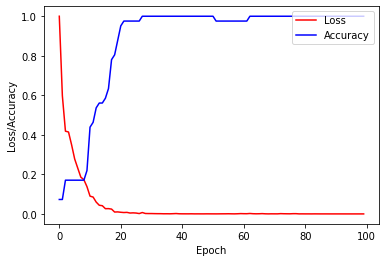

In [11]:
plt.figure()
plt.plot(range(len(losses)),losses,label='Loss', color='red')
plt.plot(range(len(accuracy)),accuracy,label='Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper right')
plt.show()
df=np.array([accuracy,losses])
df=df.T
df=pd.DataFrame(df,columns=["accuracy","loss"])
df.to_csv("result_selfts.csv")
def save_model(net, path):
    torch.save(net, path)
save_model(model, "1dcnn_Adam_RLR.pkl")

In [13]:
def myonetest(model, epoch):
    model.eval().cpu()
    correct = 0
    onepredict=[]
    onetarget=[]
    for data, target in testloader:
        
        data = data.to(torch.float32)
        
        # apply transform and model on whole batch directly on device
        output = model(data)
        
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)   
        # update progress bar
        #pbar.update(pbar_update)
        pred=list(pred.squeeze().numpy())
        target=list(target.squeeze().numpy())
        onepredict += pred
        onetarget+=target
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n")
    return (correct/(len(testloader.dataset)),onepredict,onetarget)
_,onepredict,onetarget=myonetest(model,2)
print(onepredict)
print(len(onepredict))
print(onetarget)


Test Epoch: 2	Accuracy: 41/41 (100%)

[3, 6, 2, 1, 6, 5, 6, 4, 1, 6, 2, 7, 0, 5, 4, 2, 2, 9, 7, 3, 4, 1, 8, 9, 1, 0, 7, 7, 4, 0, 4, 7, 8, 9, 8, 2, 7, 0, 7, 7, 5]
41
[3, 6, 2, 1, 6, 5, 6, 4, 1, 6, 2, 7, 0, 5, 4, 2, 2, 9, 7, 3, 4, 1, 8, 9, 1, 0, 7, 7, 4, 0, 4, 7, 8, 9, 8, 2, 7, 0, 7, 7, 5]


[[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 3]]
[['4' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '4' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '5' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '2' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '5' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '3' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '4' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '8' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '3' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '3']]


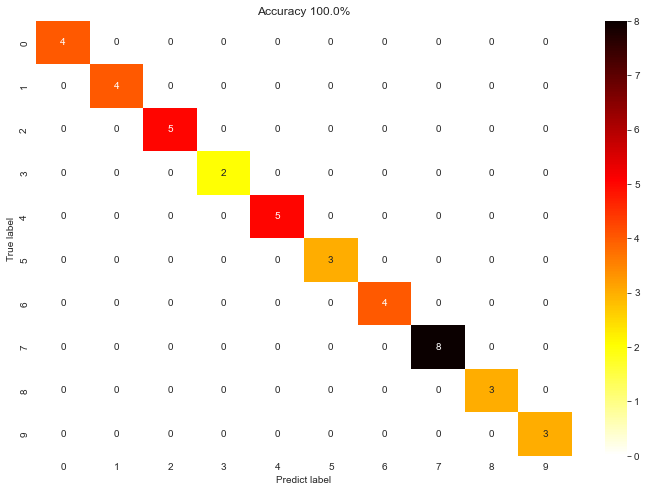

In [14]:
def myConfusionMatrixHeatmap(y_pred,y_true):
    import numpy
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    
    sns.set({'figure.figsize': [12,8]})
    f, ax = plt.subplots()
    C2 = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    #C2_Acc=C2/20*100
    annot=numpy.zeros(C2.shape).astype(int).astype(str)
    trueSum=0
    for i in range(10):
        trueSum+=C2[i][i];
        for j in range(10):
            if(C2[i][j]!=0):
                annot[i][j]="{}".format(C2[i][j])
    
    print(C2)
    print(annot)
    sns.heatmap(C2, annot=annot, fmt="", ax=ax, cmap="hot_r")  
    
    ax.set_title('Accuracy {:.1f}%'.format(trueSum/(dataset_len-trainset_len)*100)) 
    ax.set_xlabel('Predict label')  
    ax.set_ylabel('True label')  
    plt.show()
    
myConfusionMatrixHeatmap(onepredict,onetarget)